In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


# **Collecting Data**

In [2]:
data = pd.read_csv("/content/Train.csv")

In [3]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# **Data Preprocessing**

In [4]:
data.shape

(10999, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Handling missing values

In [6]:
# Check for missing values
print(data.isnull().sum())

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64


Handling Categorical Values

In [7]:
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)

Categorical columns: Index(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], dtype='object')


In [8]:
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

Handling Outliers

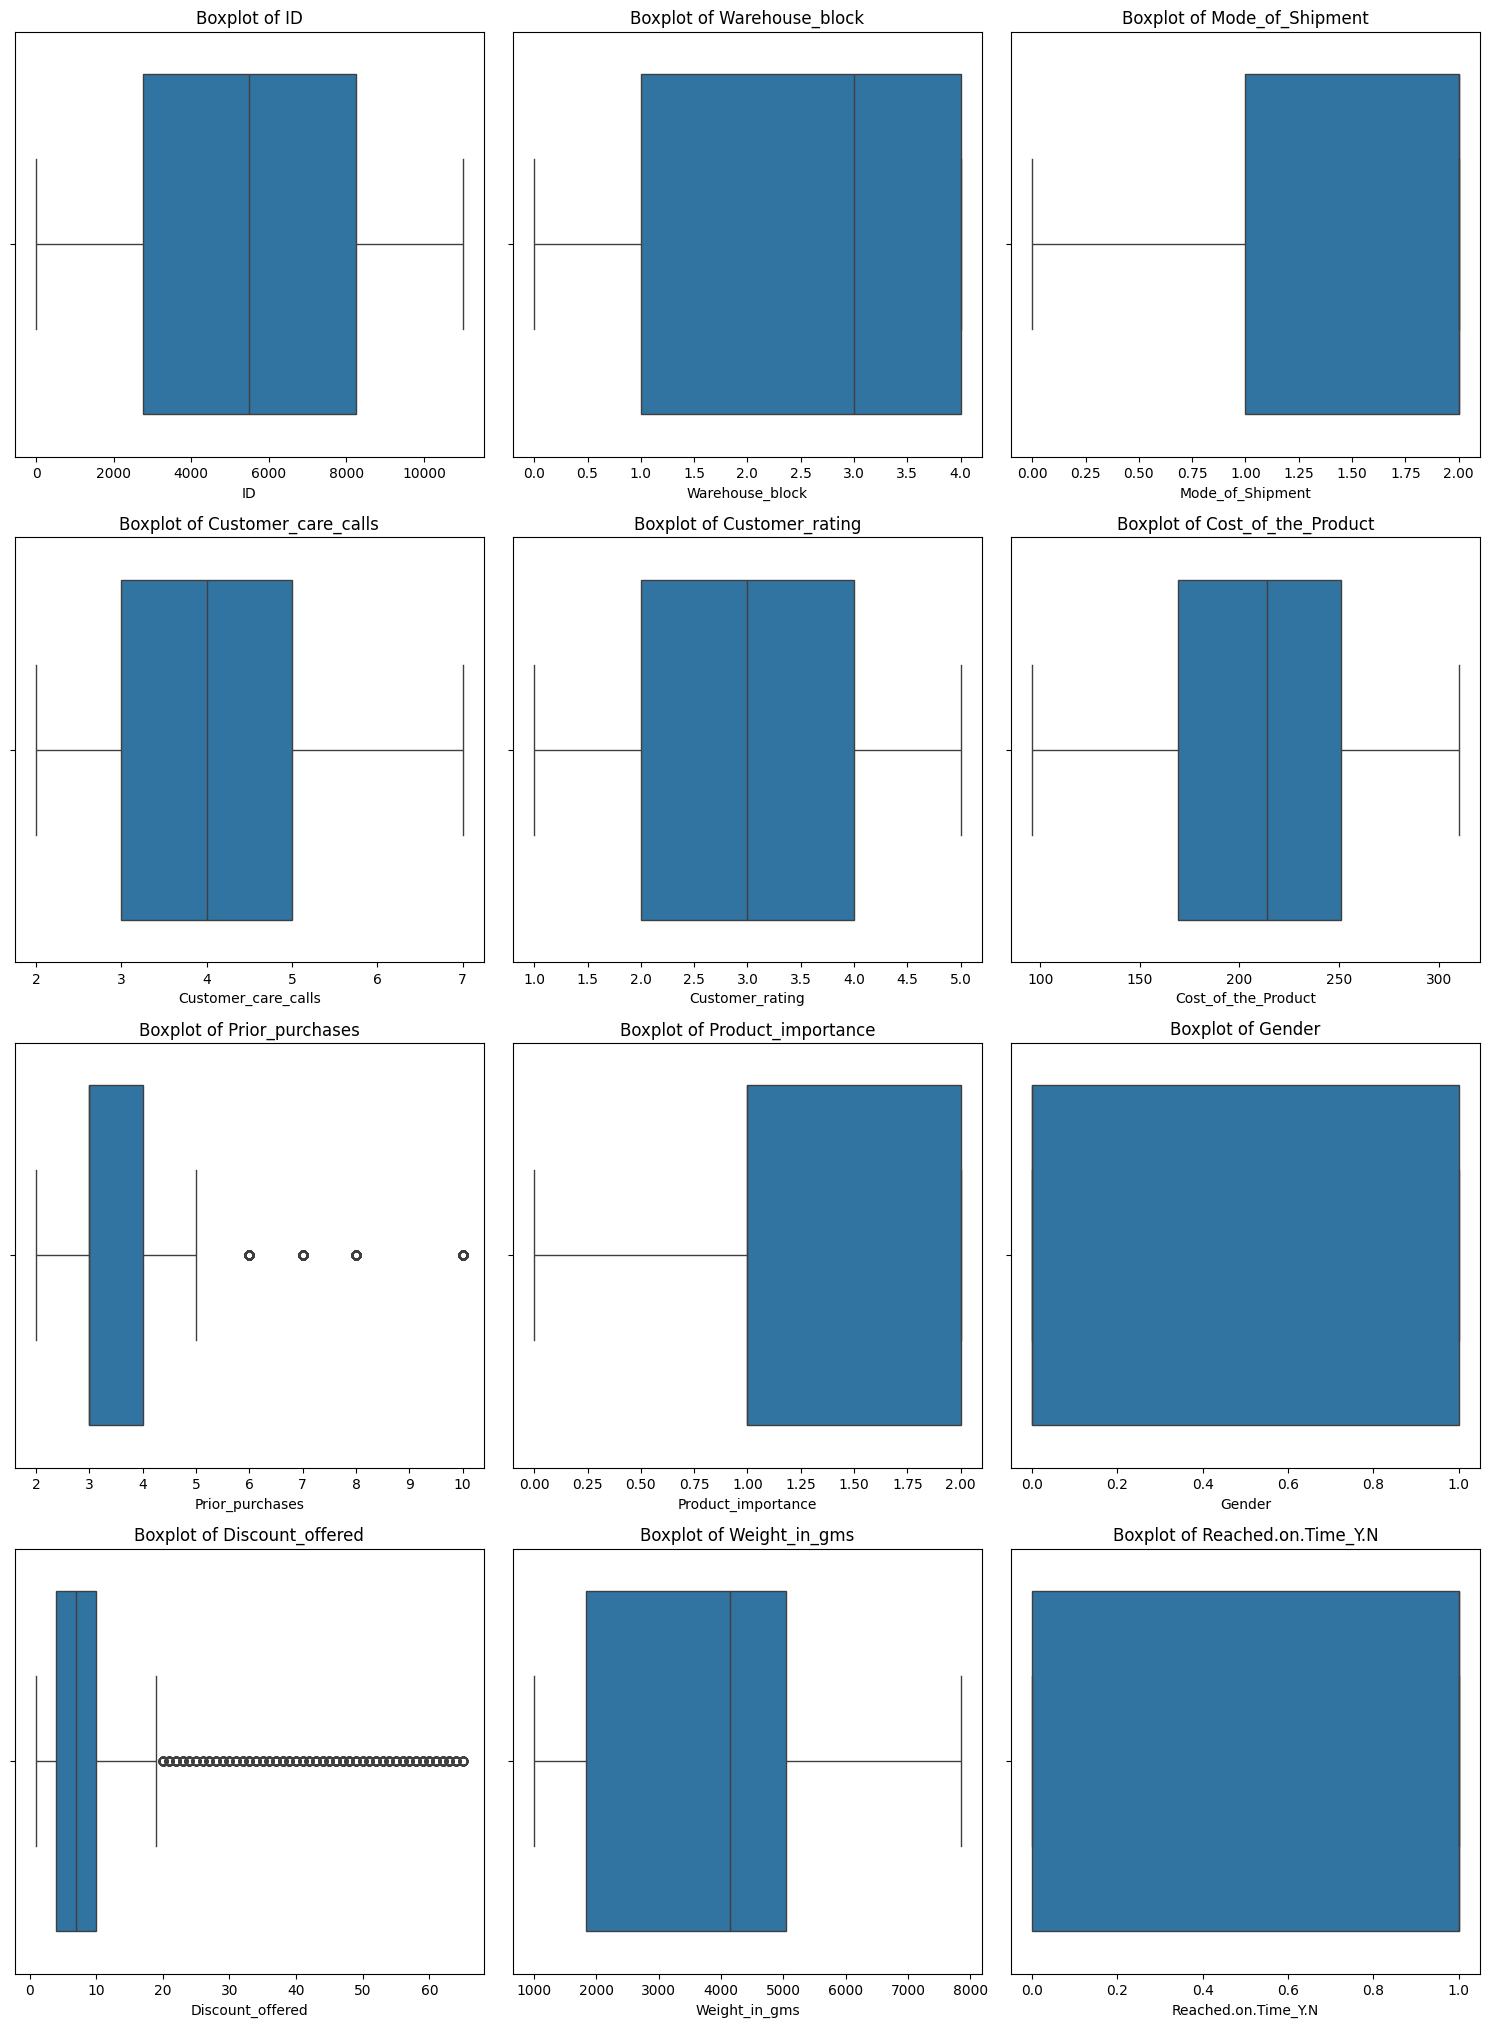

In [9]:
# Visualize outliers using boxplot
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

num_cols = 3  # Number of plots per row
num_plots = len(numerical_cols)

plt.figure(figsize=(15, 5 * (num_plots // num_cols + 1)))  # Adjust figure size based on number of plots

for i, col in enumerate(numerical_cols):
    plt.subplot((num_plots // num_cols) + 1, num_cols, i + 1)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [10]:
# Calculate upper and lower bounds using IQR
def calculate_bounds(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Apply transformation technique to handle outliers (e.g., clipping)
def clip_outliers(data, col):
    lower_bound, upper_bound = calculate_bounds(data, col)
    data[col] = np.clip(data[col], lower_bound, upper_bound)

# Apply clipping to all numerical columns
for col in numerical_cols:
    clip_outliers(data, col)

In [11]:
# Display the first few rows of the transformed dataset
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,3,0,4,2,177,3.0,1,0,19,1233,1
1,2,4,0,4,5,216,2.0,1,1,19,3088,1
2,3,0,0,2,2,183,4.0,1,1,19,3374,1
3,4,1,0,3,3,176,4.0,2,1,10,1177,1
4,5,2,0,2,2,184,3.0,2,0,19,2484,1


# **Descriptive Statistics**

In [12]:
data.describe()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,2.333394,1.516865,4.054459,2.990545,210.196836,3.421629,1.346031,0.495863,8.590963,3634.016729,0.596691
std,3175.28214,1.490726,0.756894,1.141490,1.413603,48.063272,1.136903,0.631434,0.500006,6.095461,1635.377251,0.490584
min,1.00000,0.000000,0.000000,2.000000,1.000000,96.000000,2.000000,0.000000,0.000000,1.000000,1001.000000,0.000000
25%,2750.50000,1.000000,1.000000,3.000000,2.000000,169.000000,3.000000,1.000000,0.000000,4.000000,1839.500000,0.000000
50%,5500.00000,3.000000,2.000000,4.000000,3.000000,214.000000,3.000000,1.000000,0.000000,7.000000,4149.000000,1.000000
75%,8249.50000,4.000000,2.000000,5.000000,4.000000,251.000000,4.000000,2.000000,1.000000,10.000000,5050.000000,1.000000
max,10999.00000,4.000000,2.000000,7.000000,5.000000,310.000000,5.500000,2.000000,1.000000,19.000000,7846.000000,1.000000


# **Visual Analysis**

Univariate analysis

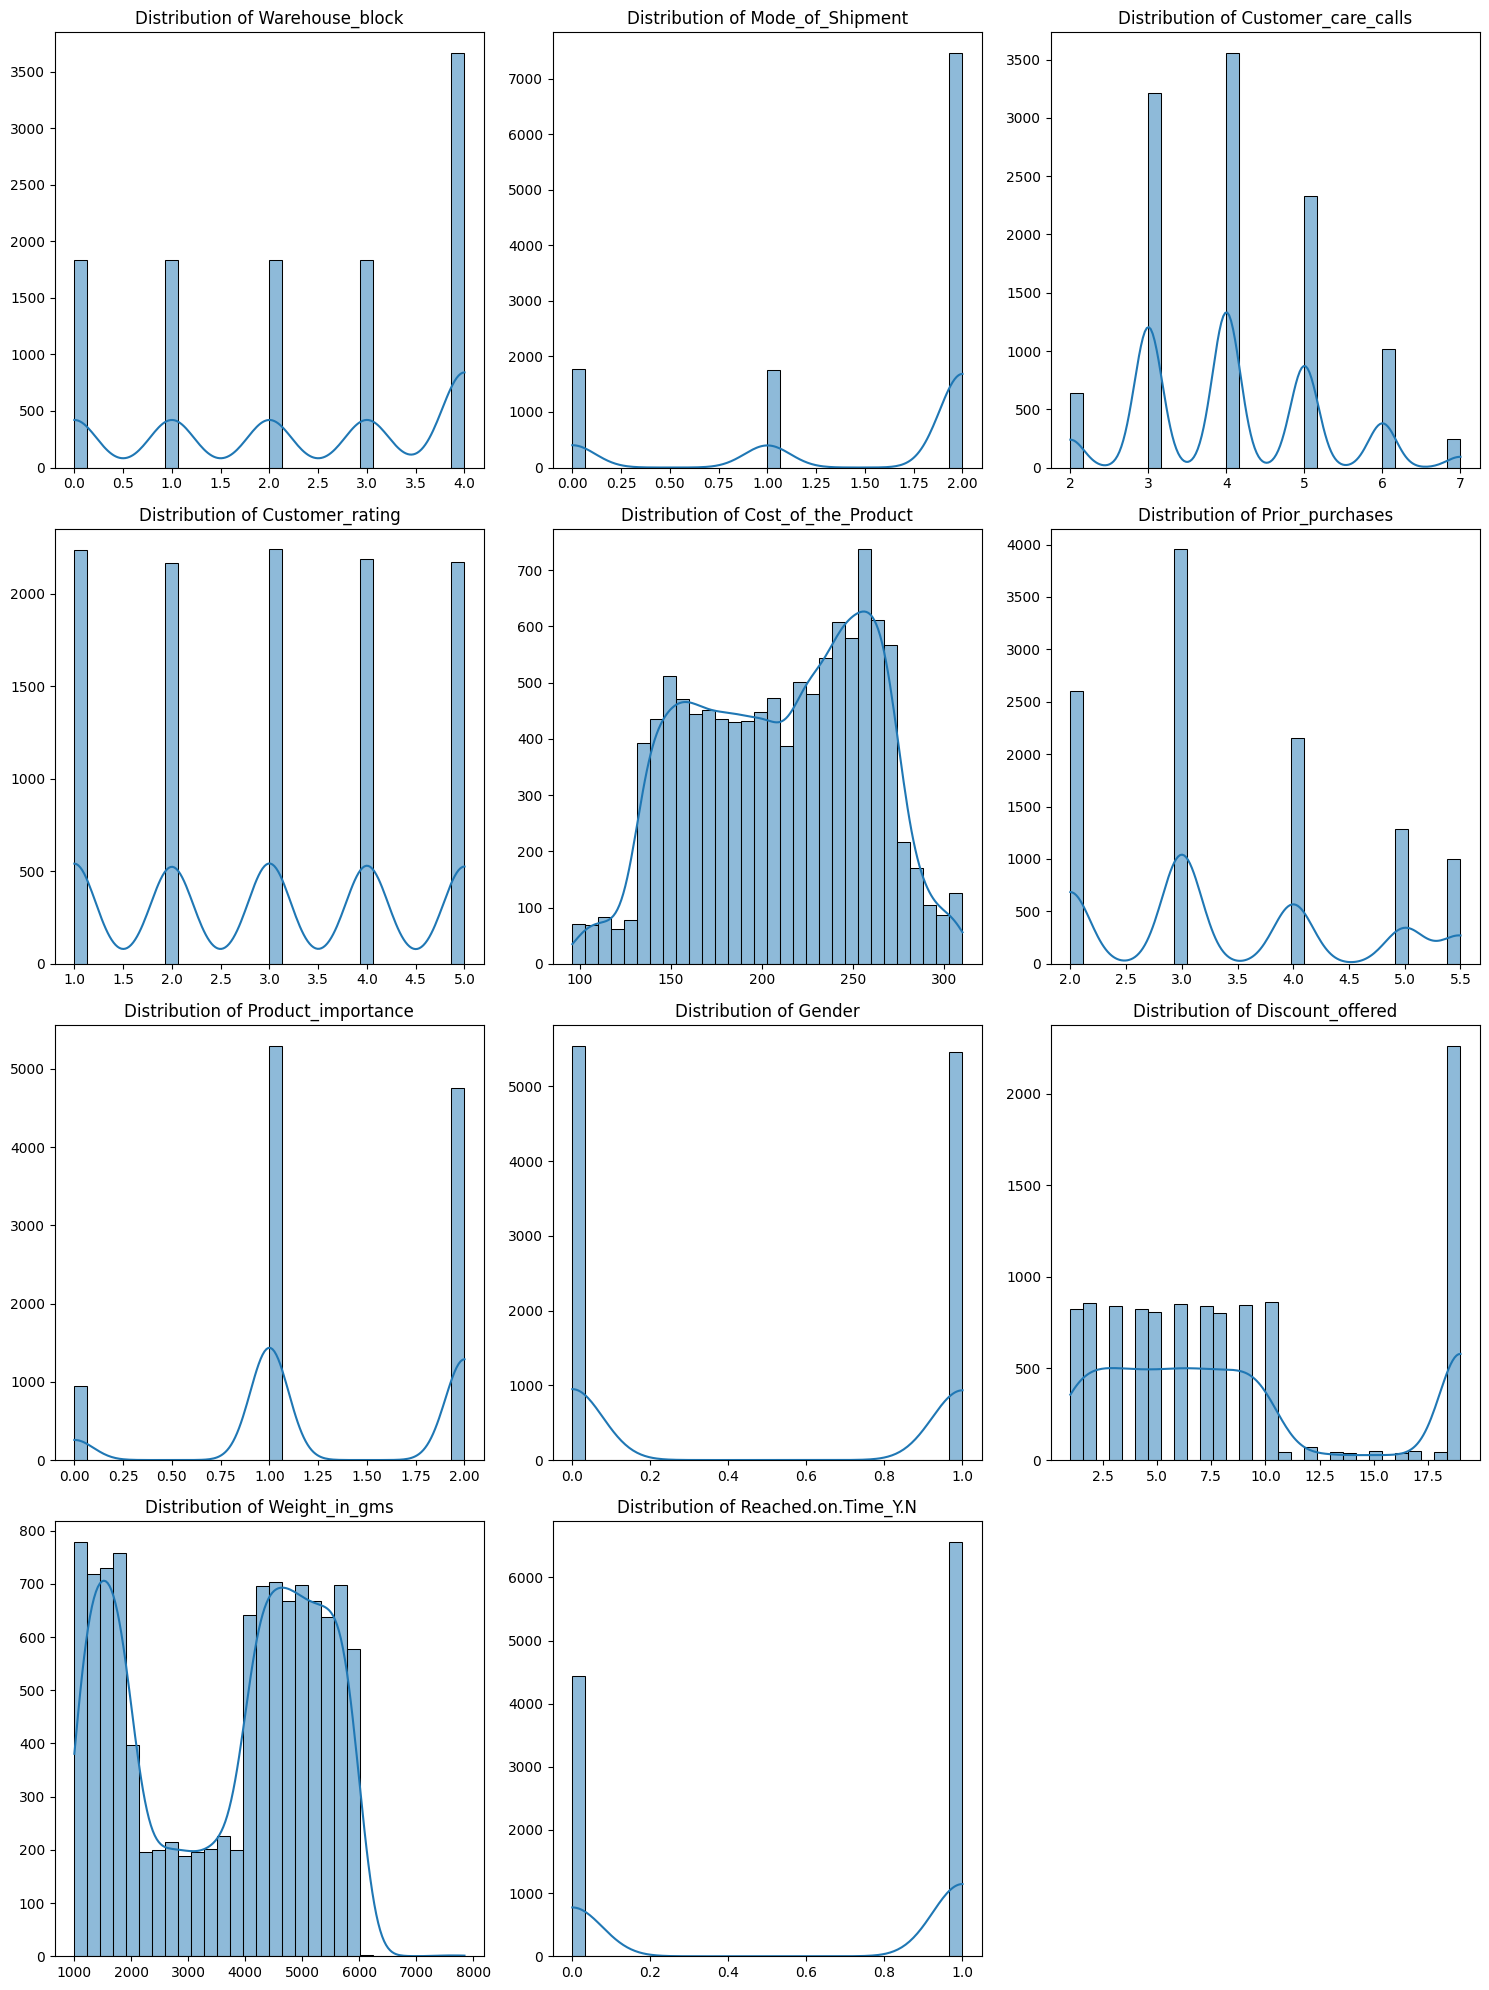

In [13]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('ID', errors='ignore')

# Number of plots per row
num_cols = 3
num_rows = -(-len(numerical_columns) // num_cols)  # Ceiling division

plt.figure(figsize=(5 * num_cols, 5 * num_rows))

for i, column in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


Bivariate analysis

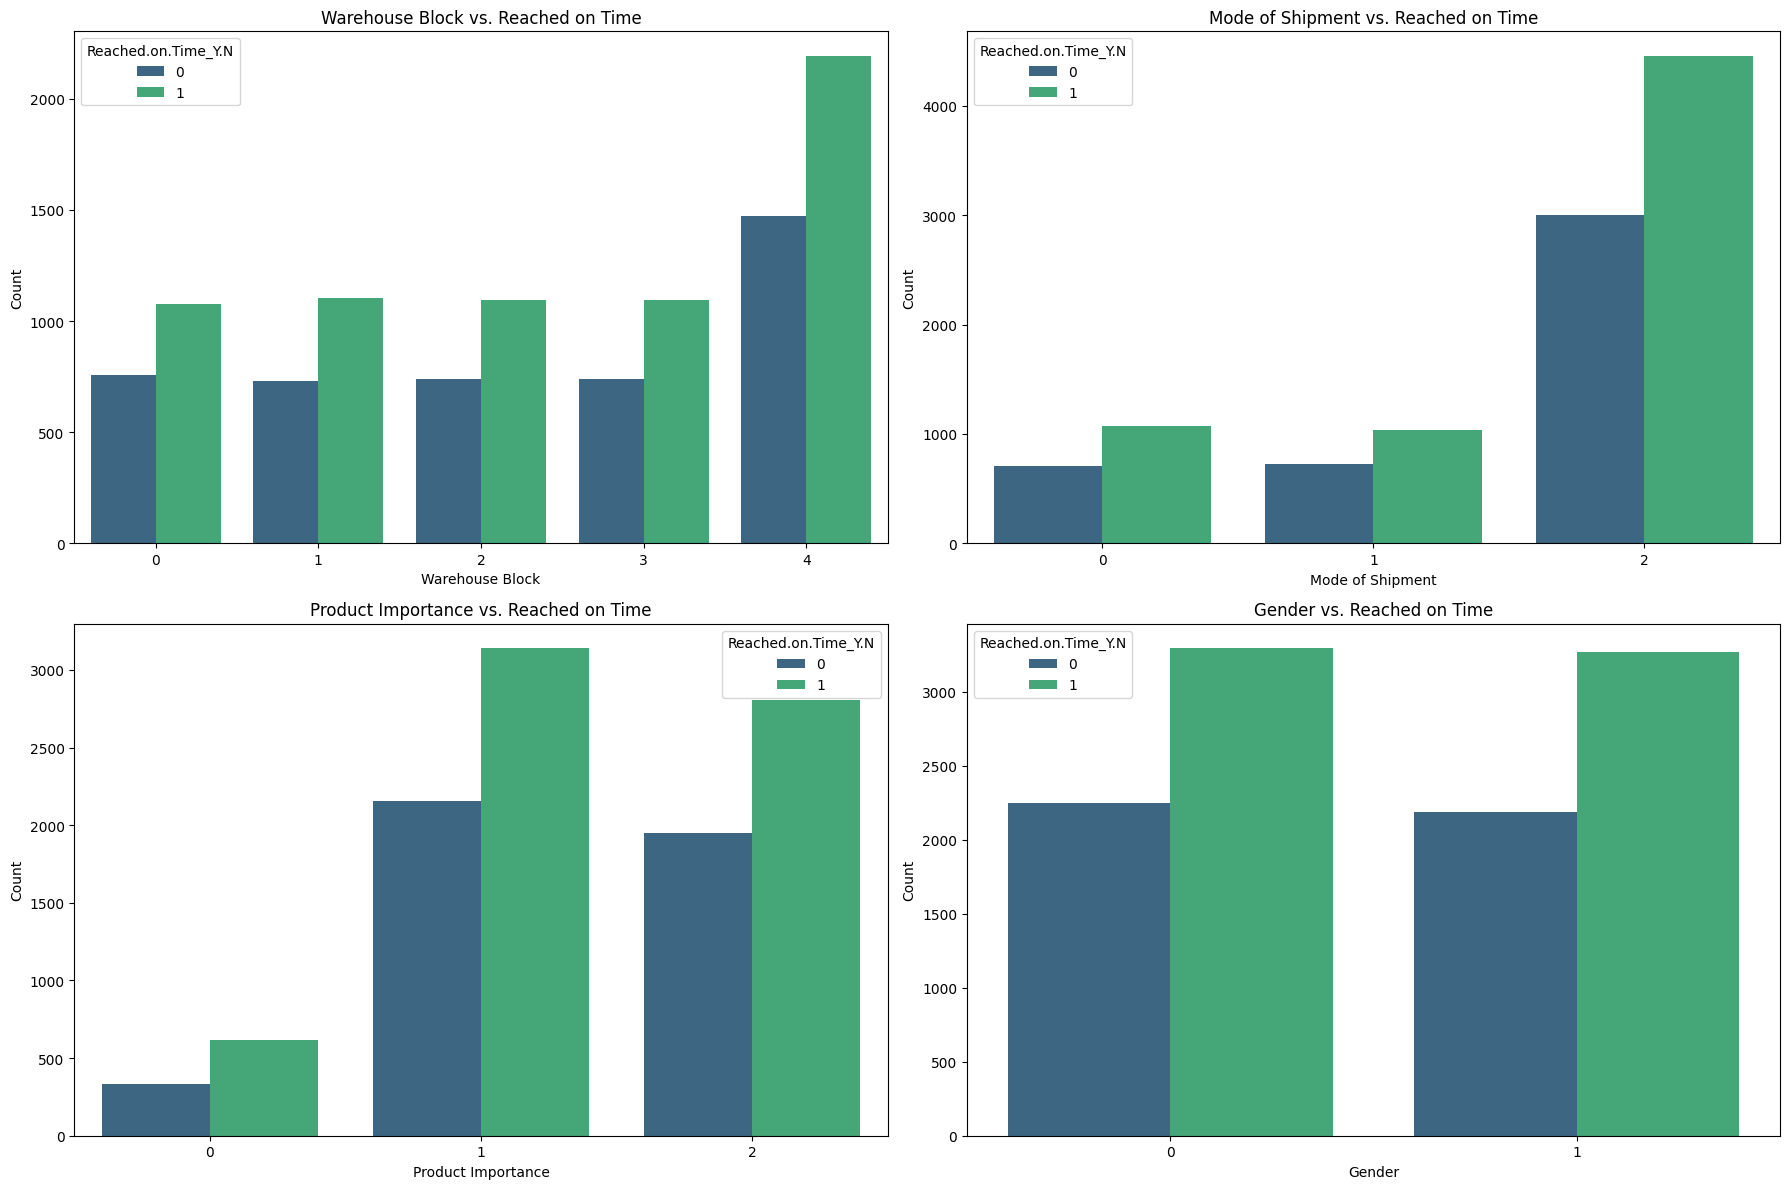

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for all plots
plt.figure(figsize=(18, 12))

# Plot 1: Warehouse Block vs. Reached on Time
plt.subplot(2, 2, 1)
sns.countplot(x='Warehouse_block', hue='Reached.on.Time_Y.N', data=data, palette='viridis')
plt.title('Warehouse Block vs. Reached on Time')
plt.xlabel('Warehouse Block')
plt.ylabel('Count')

# Plot 2: Mode of Shipment vs. Reached on Time
plt.subplot(2, 2, 2)
sns.countplot(x='Mode_of_Shipment', hue='Reached.on.Time_Y.N', data=data, palette='viridis')
plt.title('Mode of Shipment vs. Reached on Time')
plt.xlabel('Mode of Shipment')
plt.ylabel('Count')

# Plot 3: Product Importance vs. Reached on Time
plt.subplot(2, 2, 3)
sns.countplot(x='Product_importance', hue='Reached.on.Time_Y.N', data=data, palette='viridis')
plt.title('Product Importance vs. Reached on Time')
plt.xlabel('Product Importance')
plt.ylabel('Count')

# Plot 4: Gender vs. Reached on Time
plt.subplot(2, 2, 4)
sns.countplot(x='Gender', hue='Reached.on.Time_Y.N', data=data, palette='viridis')
plt.title('Gender vs. Reached on Time')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Multivariate analysis

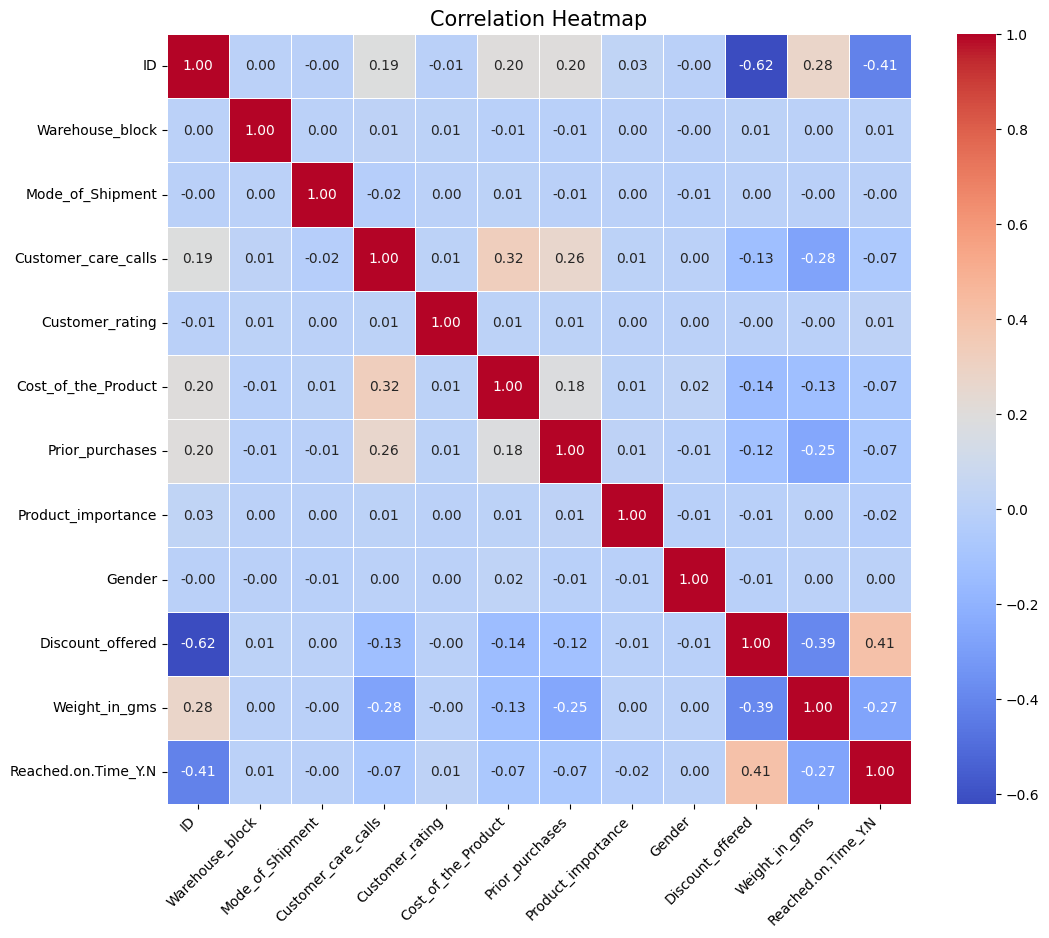

In [15]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 10})

# Title and labels
plt.title('Correlation Heatmap', size=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

# **Splitting Data**

In [16]:
# Separate the features and the target variable
x = data.drop(columns=['ID', 'Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

In [17]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8799, 10)
X_test shape: (2200, 10)
y_train shape: (8799,)
y_test shape: (2200,)


In [18]:
# Initialize the Normalizer with norm='l1'
normalizer = Normalizer(norm='l1')

# Apply normalization to x_train and x_test
x_train_normalized = normalizer.fit_transform(x_train)
x_test_normalized = normalizer.transform(x_test)

print(x_train_normalized.shape)
print(x_test_normalized.shape)

(8799, 10)
(2200, 10)


# **Training and Testing the model**

In [19]:
def models_eval(x_train, y_train, x_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(random_state=1234),
        'Logistic Regression CV': LogisticRegressionCV(random_state=1234),
        'XGBoost': XGBClassifier(random_state=1234),
        'Ridge Classifier': RidgeClassifier(random_state=1234),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(random_state=1234),
        'SVM Classifier': svm.SVC(random_state=1234)
    }

    for name, model in models.items():
        model.fit(x_train, y_train)
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f' -- {name}')
        print(f'Train Score: {train_score:.4f}')
        print(f'Test Score: {test_score:.4f}')
        print()

    return models

In [20]:
models = models_eval(x_train_normalized, y_train, x_test_normalized, y_test)

 -- Logistic Regression
Train Score: 0.5976
Test Score: 0.5932

 -- Logistic Regression CV
Train Score: 0.6315
Test Score: 0.6223

 -- XGBoost
Train Score: 0.9503
Test Score: 0.6691

 -- Ridge Classifier
Train Score: 0.5976
Test Score: 0.5932

 -- KNN
Train Score: 0.7686
Test Score: 0.6327

 -- Random Forest
Train Score: 1.0000
Test Score: 0.6695

 -- SVM Classifier
Train Score: 0.5976
Test Score: 0.5932



In [21]:
# Testing each model with the first instance in the test set
test_instance = x_test_normalized[0].reshape(1, -1)

for name, model in models.items():
    predicted_label = model.predict(test_instance)
    print(f'{name} Prediction:', predicted_label[0])


Logistic Regression Prediction: 1
Logistic Regression CV Prediction: 1
XGBoost Prediction: 1
Ridge Classifier Prediction: 1
KNN Prediction: 1
Random Forest Prediction: 1
SVM Classifier Prediction: 1


# **Testing Model With Multiple Evaluation Metrics**

In [22]:
# Define a function to evaluate models
def eval_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return [
        "{:.2f}".format(accuracy_score(y_test, y_pred) * 100),
        "{:.2f}".format(f1_score(y_test, y_pred) * 100),
        "{:.2f}".format(recall_score(y_test, y_pred) * 100),
        "{:.2f}".format(precision_score(y_test, y_pred) * 100)
    ]

# Evaluate models and store the results
model_eval_info = [
    [name] + eval_model(model, x_test_normalized, y_test)
    for name, model in models.items()
]

# Create DataFrame and save to CSV
model_eval_df = pd.DataFrame(model_eval_info, columns=['Name', 'Accuracy', 'F1 Score', 'Recall', 'Precision'])
model_eval_df.to_csv('model_eval.csv', index=False)
print(model_eval_df)


                     Name Accuracy F1 Score  Recall Precision
0     Logistic Regression    59.32    74.47  100.00     59.32
1  Logistic Regression CV    62.23    68.46   69.12     67.82
2                 XGBoost    66.91    71.43   69.73     73.21
3        Ridge Classifier    59.32    74.47  100.00     59.32
4                     KNN    63.27    68.36   66.90     69.90
5           Random Forest    66.95    69.82   64.44     76.18
6          SVM Classifier    59.32    74.47  100.00     59.32


Logistic Regression

In [23]:
# Train and evaluate Logistic Regression model
logistic_regression = LogisticRegression(random_state=1234)
logistic_regression.fit(x_train_normalized, y_train)
y_pred_lr = logistic_regression.predict(x_test_normalized)

# Classification report and confusion matrix for Logistic Regression
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       895
           1       0.59      1.00      0.74      1305

    accuracy                           0.59      2200
   macro avg       0.30      0.50      0.37      2200
weighted avg       0.35      0.59      0.44      2200



In [24]:
confusion_matrix(y_test, y_pred_lr)

array([[   0,  895],
       [   0, 1305]])

LogisticRegressionCV

In [25]:
logistic_regression_cv = LogisticRegressionCV(random_state=1234)
logistic_regression_cv.fit(x_train_normalized, y_train)
y_pred_lrcv = logistic_regression_cv.predict(x_test_normalized)

# Classification report and confusion matrix for Logistic Regression CV
print("Logistic Regression CV Classification Report")
print(classification_report(y_test, y_pred_lrcv))

Logistic Regression CV Classification Report
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       895
           1       0.68      0.69      0.68      1305

    accuracy                           0.62      2200
   macro avg       0.61      0.61      0.61      2200
weighted avg       0.62      0.62      0.62      2200



In [26]:
confusion_matrix(y_test, y_pred_lrcv)

array([[467, 428],
       [403, 902]])

XGBoost

In [27]:
xgboost = XGBClassifier(random_state=1234)
xgboost.fit(x_train_normalized, y_train)
y_pred_xgb = xgboost.predict(x_test_normalized)

# Classification report and confusion matrix for XGBoost
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       895
           1       0.73      0.70      0.71      1305

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.67      0.67      0.67      2200



In [28]:
confusion_matrix(y_test, y_pred_xgb)

array([[562, 333],
       [395, 910]])

Ridge Classifier

In [29]:
ridge_classifier = RidgeClassifier(random_state=1234)
ridge_classifier.fit(x_train_normalized, y_train)
y_pred_rc = ridge_classifier.predict(x_test_normalized)

# Classification report and confusion matrix for Ridge Classifier
print("Ridge Classifier Classification Report")
print(classification_report(y_test, y_pred_rc))

Ridge Classifier Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       895
           1       0.59      1.00      0.74      1305

    accuracy                           0.59      2200
   macro avg       0.30      0.50      0.37      2200
weighted avg       0.35      0.59      0.44      2200



In [30]:
confusion_matrix(y_test, y_pred_rc)

array([[   0,  895],
       [   0, 1305]])

K-Nearest Neighbors (KNN)

In [31]:
knn = KNeighborsClassifier()
knn.fit(x_train_normalized, y_train)
y_pred_knn = knn.predict(x_test_normalized)

# Classification report and confusion matrix for KNN
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       895
           1       0.70      0.67      0.68      1305

    accuracy                           0.63      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.64      0.63      0.63      2200



In [32]:
confusion_matrix(y_test, y_pred_knn)

array([[519, 376],
       [432, 873]])

Random Forest

In [33]:
rf_model = RandomForestClassifier(random_state=1234)
rf_model.fit(x_train_normalized, y_train)

# Predict and evaluate the model
y_pred_rf = rf_model.predict(x_test_normalized)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.71      0.63       895
           1       0.76      0.64      0.70      1305

    accuracy                           0.67      2200
   macro avg       0.67      0.68      0.67      2200
weighted avg       0.69      0.67      0.67      2200



In [34]:
confusion_matrix(y_test, y_pred_rf)

array([[632, 263],
       [464, 841]])

SVM Classifier

In [35]:
svm_model = svm.SVC(random_state=1234)
svm_model.fit(x_train_normalized, y_train)

# Predict and evaluate the model
y_pred_svm = svm_model.predict(x_test_normalized)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       895
           1       0.59      1.00      0.74      1305

    accuracy                           0.59      2200
   macro avg       0.30      0.50      0.37      2200
weighted avg       0.35      0.59      0.44      2200



In [36]:
confusion_matrix(y_test, y_pred_svm)

array([[   0,  895],
       [   0, 1305]])

# **Hyperparameter Tuning**

In [37]:
# Define the parameter grid for SVC
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize and fit GridSearchCV for SVC
svc_grid = GridSearchCV(SVC(random_state=1234), svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
svc_grid.fit(x_train_normalized, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(random_state=1234), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [38]:
# Print best parameters and score
print("Best parameters for SVC:", svc_grid.best_params_)
print("Best score for SVC:", svc_grid.best_score_)

Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVC: 0.6546212982583078


Random Forest

In [39]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
rf_param_distributions = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and fit RandomizedSearchCV for Random Forest
rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_param_distributions, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2, random_state=1234)
rf_random.fit(x_train_normalized, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1234),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=1234, scoring='accuracy', verbose=2)

In [41]:
# Print best parameters and score
print("Best parameters for Random Forest:", rf_random.best_params_)
print("Best score for Random Forest:", rf_random.best_score_)

Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'gini'}
Best score for Random Forest: 0.6768951017161041


XGBoost

In [42]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

# Initialize and fit GridSearchCV for XGBoost
xgb_grid = GridSearchCV(XGBClassifier(random_state=1234), xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
xgb_grid.fit(x_train_normalized, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1234, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [43]:
# Print best parameters and score
print("Best parameters for XGBoost:", xgb_grid.best_params_)
print("Best score for XGBoost:", xgb_grid.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
Best score for XGBoost: 0.6754183032714869


Logistic Regression CV

In [44]:
# Define the parameter grid for Logistic Regression CV
log_reg_cv_param_grid = {
    'Cs': [1, 10, 100],
    'cv': [5, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize and fit GridSearchCV for Logistic Regression CV
log_reg_cv_grid = GridSearchCV(LogisticRegressionCV(random_state=1234), log_reg_cv_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
log_reg_cv_grid.fit(x_train_normalized, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegressionCV(random_state=1234), n_jobs=-1,
             param_grid={'Cs': [1, 10, 100], 'cv': [5, 10],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=2)

In [45]:
# Print best parameters and score
print("Best parameters for Logistic Regression CV:", log_reg_cv_grid.best_params_)
print("Best score for Logistic Regression CV:", log_reg_cv_grid.best_score_)

Best parameters for Logistic Regression CV: {'Cs': 10, 'cv': 5, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression CV: 0.6306418936379142


# **Saving the best model**

In [46]:
import pickle as pkl

# Find the best model based on accuracy
best_model_name = max(model_eval_info, key=lambda x: float(x[1]))[0]
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

# Save the best model and the normalizer
pkl.dump(best_model, open(f'{best_model_name}_best_model.pkl', 'wb'))
pkl.dump(normalizer, open('normalizer.pkl', 'wb'))


Best Model: Random Forest


In [47]:
from google.colab import files

files.download(f'{best_model_name}_best_model.pkl')
files.download('normalizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv("/content/Train.csv")

# Initialize LabelEncoders for each categorical column
label_encoders = {
    'Warehouse_block': LabelEncoder(),
    'Mode_of_Shipment': LabelEncoder(),
    'Product_importance': LabelEncoder(),
    'Gender': LabelEncoder()
}

# Fit the LabelEncoders on the categorical columns
for column, encoder in label_encoders.items():
    encoder.fit(data[column])
    # Save each LabelEncoder as a .pkl file
    with open(f'label_encoder_{column.lower()}.pkl', 'wb') as file:
        pickle.dump(encoder, file)

print("Label encoders saved successfully.")


Label encoders saved successfully.
